# Lec02 (AI4Science): Linear Regression for Smarter Experiments
 
**Theme:** Use a simple ML model to reduce trial-and-error in scientific experimentation.

---

## Scientific Research Context

A chemistry lab runs experiments to synthesize a molecule. Each experiment run/measurements is expensive and slow. The lab can control conditions:

- Temperature (°C)
- Reaction time (minutes)
- Catalyst amount (mol%)

The measured outcome is **reaction yield (%)** for the to be synthesized molecule.

We will learn how to:
1. Translate the science question into data **(X, y)**  
2. Fit a baseline ML model (linear regression)  
3. Evaluate if it generalizes (train/test)  
4. Interpret coefficients as *scientific effects*  
5. Gradually scale from 1 variable → multiple variables → matrix form.

> **Big idea:** In AI for Science, a "model" is a quantitative hypothesis you can test and refine.

---

### Jupyter notebook
- **Markdown cells** write notes, documents, formulas.
- **Code cells** are runnable code.


## 0. Setup

We will use:
- `numpy` for arrays
- `pandas` for tables
- `matplotlib` for plots
- `scikit-learn` for linear regression and train/test splitting

If you are running this in Colab, these are already available.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(7)  # reproducibility for classroom demos


## 1. Part A — One-variable linear regression (Temperature → Yield)

### 1.1 Scientific question
**Question:** Over the temperature range we tested, how does yield change with temperature?

We will model:
$\hat{y} = w x + b$

- \(x\): temperature (°C)  
- \(y\): yield (%)  
- \(w\): *sensitivity* (yield change per °C)  
- \(b\): baseline offset

### 1.2 Why this is machine learning
We choose \(w, b\) by minimizing a loss function on data:

$L(w,b) = \sum_i (y_i - (w x_i + b))^2$

This is *learning from examples*.


### 1.3 Create a small dataset (synthetic but realistic)

To keep this workshop lightweight and reproducible, we generate a dataset that resembles lab measurements:
- True trend: yield increases with temperature (within a safe range)
- Noise: measurement error + uncontrolled factors

**Important:** The scatter is not a bug; it's what real science data looks like.


In [ ]:
# Generate temperatures (°C)
n = 35
temp = np.linspace(35, 75, n)

# A simple "true" relationship (unknown to the model)
true_w = 0.55      # yield change per °C change
true_b = 5.0       # baseline yield at 0°C (not physically meaningful, but mathematically fine)

# Add noise (real lab variability + unobserved variables/factors influences)
noise = np.random.normal(loc=0.0, scale=3.5, size=n)  # std dev ~ 3.5 yield points

yield_pct = true_w * temp + true_b + noise

df_1d = pd.DataFrame({"temp_C": temp, "yield_pct": yield_pct})
df_1d.head()


,temp_C,yield_pct
0,35.000000,30.166840
1,36.176471,23.266278
2,37.352941,25.658988
3,38.529412,27.617483
4,39.705882,24.077005


### 1.4 Plot the data
Always start by plotting. A scatter plot is the fastest sanity check in science and in ML.

- If points roughly form a tilted cloud → linear trend may be reasonable
- If points curve strongly → linear may be a poor model (we can improve later)


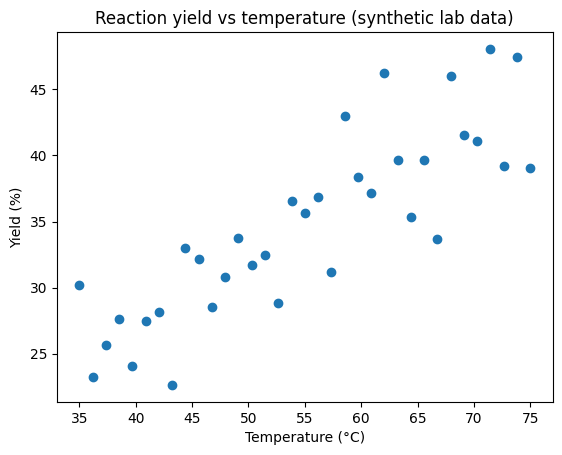

In [4]:
plt.figure()
plt.scatter(df_1d["temp_C"], df_1d["yield_pct"])
plt.xlabel("Temperature (°C)")
plt.ylabel("Yield (%)")
plt.title("Reaction yield vs temperature (synthetic lab data)")
plt.show()


## 2. Fitting the 1D model in Python

We will:
1. Split the data into train/test sets
2. Fit a linear regression model on train data
3. Evaluate on test data
4. Interpret the fitted slope and intercept

### Why train/test?
If you evaluate on the same data you fit on, you can fool yourself.  
Test error approximates how well you will do on future experiments.


In [5]:
X = df_1d[["temp_C"]]  # sklearn expects 2D features (n_samples, n_features)
y = df_1d["yield_pct"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7
)

model_1d = LinearRegression()
model_1d.fit(X_train, y_train)

w_hat = float(model_1d.coef_[0])
b_hat = float(model_1d.intercept_)

w_hat, b_hat


(0.49118095987066196, 8.126436237110614)

### 2.1 Interpret the fitted parameters (AI for Science emphasis)

- **Slope \(w\)** is a scientific statement:  
  > “Within our tested range, yield changes by about \(w\) percentage points for each +1°C.”

- **Intercept \(b\)** is the model's baseline at 0°C.  
  It may not be physically meaningful, but it helps define the line.

**Exercise (quick mental math):**  
If \(w = 0.5\), what yield change do you expect for +10°C?

Now we will compute predictions and evaluate.


In [6]:
y_pred_test = model_1d.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Fitted model: yield = {w_hat:.3f} * temp + {b_hat:.3f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R^2: {r2:.3f}")


Fitted model: yield = 0.491 * temp + 8.126
Test MSE: 10.255
Test R^2: 0.546


### 2.2 Visualize the fitted line (and what it means)

We overlay the fitted line on the scatter plot.


c:\Users\zhou\miniconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


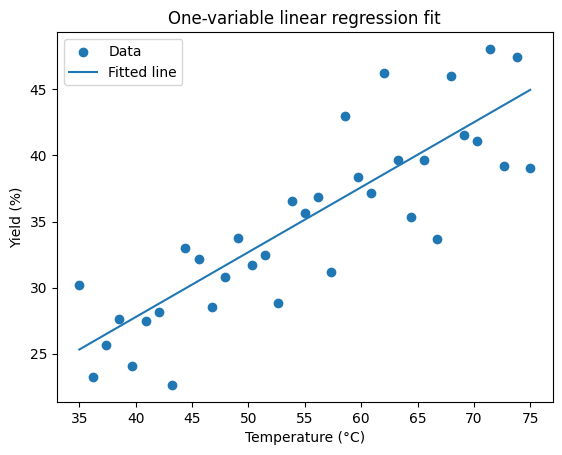

In [7]:
plt.figure()
plt.scatter(df_1d["temp_C"], df_1d["yield_pct"], label="Data")

temp_grid = np.linspace(df_1d["temp_C"].min(), df_1d["temp_C"].max(), 200)
pred_line = model_1d.predict(temp_grid.reshape(-1, 1))

plt.plot(temp_grid, pred_line, label="Fitted line")
plt.xlabel("Temperature (°C)")
plt.ylabel("Yield (%)")
plt.title("One-variable linear regression fit")
plt.legend()
plt.show()


## 3. Residuals: model criticism (how scientists think)

Residual = actual - predicted: $r_i = y_i - \hat{y}_i$


If residuals show structure (e.g., curve), the model may be missing physics/chemistry.
If residuals look like random noise around 0, linear might be acceptable.


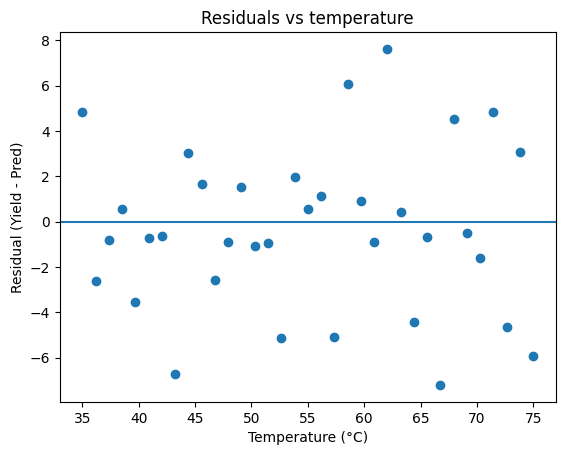

In [8]:
df_1d["pred_1d"] = model_1d.predict(X)
df_1d["residual_1d"] = df_1d["yield_pct"] - df_1d["pred_1d"]

plt.figure()
plt.scatter(df_1d["temp_C"], df_1d["residual_1d"])
plt.axhline(0)
plt.xlabel("Temperature (°C)")
plt.ylabel("Residual (Yield - Pred)")
plt.title("Residuals vs temperature")
plt.show()


## 4. A real-world issue: outliers (bad runs)

In lab science, some runs fail due to contamination or operator error.
Squared error heavily penalizes outliers, so one bad run can pull the line.

We will simulate one bad run and see how parameters change.


In [9]:
df_out = df_1d.copy()

# Add a single outlier: normal temperature but very low yield (failed run)
outlier_temp = 60.0
outlier_yield = 10.0
df_out.loc[len(df_out)] = [outlier_temp, outlier_yield, np.nan, np.nan]

X_out = df_out[["temp_C"]]
y_out = df_out["yield_pct"]

model_out = LinearRegression().fit(X_out, y_out)
w_out = float(model_out.coef_[0])
b_out = float(model_out.intercept_)

print("Original fit:", f"w={w_hat:.3f}, b={b_hat:.3f}")
print("With outlier :", f"w={w_out:.3f}, b={b_out:.3f}")


Original fit: w=0.491, b=8.126
With outlier : w=0.464, b=8.484


### 4.1 Visualize the outlier effect


c:\Users\zhou\miniconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\zhou\miniconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


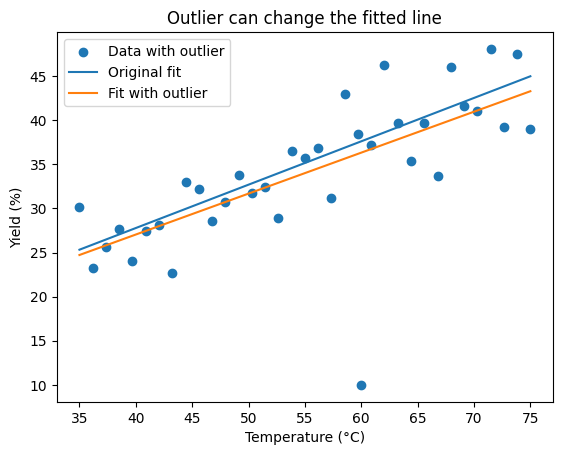

In [10]:
plt.figure()
plt.scatter(df_out["temp_C"], df_out["yield_pct"], label="Data with outlier")

temp_grid = np.linspace(df_out["temp_C"].min(), df_out["temp_C"].max(), 200)

pred_line_original = model_1d.predict(temp_grid.reshape(-1, 1))
pred_line_outlier = model_out.predict(temp_grid.reshape(-1, 1))

plt.plot(temp_grid, pred_line_original, label="Original fit")
plt.plot(temp_grid, pred_line_outlier, label="Fit with outlier")

plt.xlabel("Temperature (°C)")
plt.ylabel("Yield (%)")
plt.title("Outlier can change the fitted line")
plt.legend()
plt.show()


> *robust regression* or *data quality control* is a scientific necessity.
We are not teaching robust regression today; we are teaching that **modeling choices and lab practice interact**.


## 5. Part B — Move to multiple variables (Temperature + Time + Catalyst → Yield)

Now we ask a more realistic science question:

**Question:** How do multiple experimental knobs jointly affect yield?

We model:

$\hat{y} = w_1 \cdot \text{Temp} + w_2 \cdot \text{Time} + w_3 \cdot \text{Catalyst} + b$


**Interpretation changes (important):**
- \(w_1\) is the effect of temperature **holding time and catalyst constant**.
- \(w_2\) is the effect of time **holding temperature and catalyst constant**.
- \(w_3\) is the effect of catalyst **holding the others constant**.

This “controlling for other factors” is one reason linear regression is so common in scientific papers.


### 5.1 Generate a multivariable dataset

We simulate:
- Temperature in [35, 75] °C
- Time in [10, 60] minutes
- Catalyst in [0.2, 2.0] mol%

We also optionally introduce mild correlation between variables (common in real labs).


In [11]:
n2 = 120

temp2 = np.random.uniform(35, 75, size=n2)

# time partly correlated with temperature (optional realism)
time2 = np.random.uniform(10, 60, size=n2) + 0.15 * (temp2 - temp2.mean())

catalyst2 = np.random.uniform(0.2, 2.0, size=n2)

# True underlying relationship (unknown to the model)
wT, wTime, wCat, b0 = 0.40, 0.18, 6.0, -8.0

noise2 = np.random.normal(0.0, 4.0, size=n2)

yield2 = wT * temp2 + wTime * time2 + wCat * catalyst2 + b0 + noise2

df_3d = pd.DataFrame({
    "temp_C": temp2,
    "time_min": time2,
    "catalyst_molpct": catalyst2,
    "yield_pct": yield2
})

df_3d.head()


,temp_C,time_min,catalyst_molpct,yield_pct
0,61.295979,57.299912,1.154370,31.109956
1,49.814043,32.177148,0.277706,14.384885
2,53.363719,48.351543,1.875718,27.312723
3,63.772965,54.650764,0.844806,29.799003
4,51.519673,39.983559,1.516558,24.117769


### 5.2 Fit multivariable linear regression
We use the same workflow:
- `X` is now a matrix with 3 columns
- `y` is still a vector of yields

**Exercise:** Before you run it, guess which coefficient will be largest in effect on yield.
(Think: 1 unit of catalyst is a lot compared to 1°C.)


In [12]:
X = df_3d[["temp_C", "time_min", "catalyst_molpct"]]
y = df_3d["yield_pct"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7
)

model_3d = LinearRegression()
model_3d.fit(X_train, y_train)

coef = pd.Series(model_3d.coef_, index=X.columns)
intercept = float(model_3d.intercept_)

y_pred_test = model_3d.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Coefficients:")
display(coef.sort_values(ascending=False))
print(f"Intercept: {intercept:.3f}")
print(f"Test MSE: {mse:.3f}")
print(f"Test R^2: {r2:.3f}")


Coefficients:


catalyst_molpct    4.803133
temp_C             0.410262
time_min           0.171661
dtype: float64

Intercept: -7.865
Test MSE: 28.235
Test R^2: 0.617


### 5.3 Interpret coefficients as scientific effects

If the fitted model returns:
- \(w_T = 0.38\)
- \(w_{time} = 0.20\)
- \(w_{cat} = 5.7\)

Then the model is saying:
- +1°C increases yield by ~0.38 points (if time and catalyst fixed)
- +1 minute increases yield by ~0.20 points (if temp and catalyst fixed)
- +1 mol% catalyst increases yield by ~5.7 points (if temp and time fixed)

which coefficient is “largest” depends on units.  
A better comparison is: *typical change* in each variable × coefficient.


## 6. Compare 1-variable vs 3-variable models (why more features can help)

We fit a 1-variable model using only temperature on the same multivariable dataset, then compare test performance.


In [13]:
X1 = df_3d[["temp_C"]]
y = df_3d["yield_pct"]

X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.25, random_state=7
)

model_temp_only = LinearRegression().fit(X1_train, y_train)
y_pred_temp_only = model_temp_only.predict(X1_test)

mse_1 = mean_squared_error(y_test, y_pred_temp_only)
r2_1 = r2_score(y_test, y_pred_temp_only)

print("Temp-only model:")
print(f"  w={model_temp_only.coef_[0]:.3f}, b={model_temp_only.intercept_:.3f}")
print(f"  Test MSE={mse_1:.3f}, Test R^2={r2_1:.3f}")

print("\n3-variable model:")
print(f"  Test MSE={mse:.3f}, Test R^2={r2:.3f}")


Temp-only model:
  w=0.467, b=0.025
  Test MSE=51.329, Test R^2=0.304

3-variable model:
  Test MSE=28.235, Test R^2=0.617


**Discussion prompts:**
1. Did adding features improve test error? Why?
2. When might adding features *not* help? (hint: noisy features, too few data, collinearity)


## 7. Linear algebra view (bridge to what you're learning)

Let:
- \(X\) be an \(n \times d\) matrix (n experiments, d features)
- \(w\) be a \(d \times 1\) vector of coefficients
- \(y\) be an \(n \times 1\) vector of outputs

Then:

$\hat{y} = Xw + b\mathbf{1}$

If we add a column of ones to \(X\), we can absorb \(b\) into the coefficient vector:
$\hat{y} = X' w'$

The least squares solution satisfies a linear system (the normal equations):
$X^T X w = X^T y$

You do **not** need to solve this by hand in practice, but this is why linear regression connects naturally to linear algebra.


### 7.1 Optional: compute the normal-equation solution (for curiosity)

This is not required for the workshop. It's included to show the connection to linear algebra.


In [14]:
# Build X' by adding a bias column of ones
Xmat = X.values
ones = np.ones((Xmat.shape[0], 1))
Xprime = np.hstack([ones, Xmat])  # first column is bias

yvec = y.values.reshape(-1, 1)

# Solve (X'ᵀ X') w' = X'ᵀ y
A = Xprime.T @ Xprime
b = Xprime.T @ yvec

wprime = np.linalg.solve(A, b)  # w' = [intercept, w1, w2, w3]

wprime.ravel()


array([-7.11634105,  0.38607953,  0.17864094,  5.19673015])

## 8. Exercises (fill in the TODOs)

### Exercise 1: Make a prediction for a new experiment
You propose conditions:
- Temperature = 65°C
- Time = 45 minutes
- Catalyst = 1.2 mol%

Compute predicted yield using the 3-variable model.


In [15]:
new_conditions = pd.DataFrame({
    "temp_C": [65.0],
    "time_min": [45.0],
    "catalyst_molpct": [1.2]
})

# TODO: compute prediction using model_3d
pred_yield = model_3d.predict(new_conditions)[0]

print(f"Predicted yield: {pred_yield:.2f}%")


Predicted yield: 32.29%


### Exercise 2: Sensitivity analysis (scientific “what if”)
Holding two variables fixed, how much does predicted yield change when you adjust one variable?

Try:
- Increase temperature by +5°C (hold time and catalyst fixed)
- Increase time by +10 minutes
- Increase catalyst by +0.5 mol%

**Goal:** connect coefficients to practical decisions.


In [16]:
base = pd.DataFrame({"temp_C":[60.0], "time_min":[30.0], "catalyst_molpct":[1.0]})
base_pred = model_3d.predict(base)[0]

temp_up = base.copy(); temp_up["temp_C"] += 5.0
time_up = base.copy(); time_up["time_min"] += 10.0
cat_up  = base.copy(); cat_up["catalyst_molpct"] += 0.5

pred_temp_up = model_3d.predict(temp_up)[0]
pred_time_up = model_3d.predict(time_up)[0]
pred_cat_up  = model_3d.predict(cat_up)[0]

print(f"Base prediction: {base_pred:.2f}%")
print(f"+5°C changes prediction by: {pred_temp_up - base_pred:.2f} yield points")
print(f"+10 min changes prediction by: {pred_time_up - base_pred:.2f} yield points")
print(f"+0.5 mol% catalyst changes prediction by: {pred_cat_up - base_pred:.2f} yield points")


Base prediction: 26.70%
+5°C changes prediction by: 2.05 yield points
+10 min changes prediction by: 1.72 yield points
+0.5 mol% catalyst changes prediction by: 2.40 yield points


### Exercise 3 (challenge): Detect collinearity
Compute the correlation matrix among the features.  
If two features are highly correlated, interpreting coefficients becomes harder.

**Question:** Which pair is most correlated here?


In [17]:
corr = df_3d[["temp_C", "time_min", "catalyst_molpct"]].corr()
corr


,temp_C,time_min,catalyst_molpct
temp_C,1.000000,0.224295,0.044794
time_min,0.224295,1.000000,0.123438
catalyst_molpct,0.044794,0.123438,1.000000


## 9. Wrap-up: what you learned today

You now can:
- Translate a scientific problem into supervised learning (X → y)
- Fit and evaluate linear regression
- Interpret coefficients as scientific effects (controlling for other variables)
- Understand why linear regression is a common baseline in AI for Science

### Possible further stuff (future sessions)
- Nonlinear features (polynomials, interactions)
- Regularization (ridge/lasso) for stability and feature selection
- Classification (logistic regression) for case/control problems
- kNN and similarity graphs (used widely in single-cell biology)
- Uncertainty and experimental design (active learning)
